##### The latest version of this Jupyter notebook is available at [http://github.com/jckantor/CBE40455](http://github.com/jckantor/CBE20255)  for noncommercial use under terms of the [Creative Commons Attribution Noncommericial ShareAlike License](http://creativecommons.org/licenses/by-nc-sa/4.0/).

J.C. Kantor (Kantor.1@nd.edu)

# Real Options

## Replicating Portfolios

The concept of a 'replicating portfolio' underpins the use options pricing theory in the valuation of real business ventures.  The idea is to construct a portfolio of assets that  credibly replicates the payoff of a business venture under all possible scenarios. If such a portfolio can be constructed, then the price of the portfolio establishes a market price for the business venture.

Let's construct some simple examples before going further.

## Replicating a known cash flow with a cash account.

Suppose we are considering the purchase of lease on property that could generate $10,000 per year of income for the next 10 years. We assume there is virtually no risk that the full of those payments will not be received. 

We use the following time line to define variables:

![](../img/Timeline.png)

The value of the portfolio at time step $k$ is designated $W_k$ and is assumed to consist of only of cash equivalents in the amount $y_k$ that may be deposited with an annual interest rate $r$.

$$W_k = y_k$$

Upon expiration the value of the lease is zero, thus

$$W_N = y_N = 0$$

for a lease $N=10$ years in length. The rental income $P_k$ is received at the beginning of each year $k$. The replicating portfolio must generate a payment equal to this amount at the beginning of the year, then at the end of the year retain enough value to self-finance the portfolio for the following year. This holds true for every year, thus

$$(1+r)(y_{k-1} - P_k) = y_k$$

Collectively, this establishes a difference equation

$$y_{k-1} = \frac{y_k}{1+r} + P_k$$

where $y_N = 0$. The solution for $y_0$ gives the initial amount of money needed to create a cash portfolio replicating the lease payments.

This model can be recast as an optimization problem by finding the minimum amount of initial cash is required to create a self-financing portfolio.

\begin{align*}
& \min_{y_0,y_1,y_2,\ldots, y_N}  y_0 \\
\mbox{subject to:}\qquad\qquad \\
y_k & \geq 0 & \forall k = 0,1,\ldots,N \\
y_{k-1} & = \frac{y_k}{1+r} + P_k & \forall k = 1, 2, \ldots, N
\end{align*}

In [89]:
# problem data
N = 10
r = 0.10
P = 10000

# create model
m = ConcreteModel()

# decision variable
Periods = [k for k in range(0,N+1)]
m.y = Var(Periods,domain=NonNegativeReals)

# self-financing constraints
m.cons = ConstraintList()
for k in range(1,N+1):
    m.cons.add((1+r)*(m.y[k-1] - P) >= m.y[k])
    
# find minimum cost portfolio that satisfies the self-financing constraint
m.OBJ = Objective(expr = m.y[0], sense=minimize)
SolverFactory('glpk').solve(m).write()

# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: 67590.2381627515
  Upper bound: 67590.2381627515
  Number of objectives: 1
  Number of constraints: 11
  Number of variables: 12
  Number of nonzeros: 21
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Termination condition: optimal
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 0
      Number of created subproblems: 0
  Error rc: 0
  Time: 0.02179098129272461
# ----------------------------------------------------------
#   Solution Information
# ------------

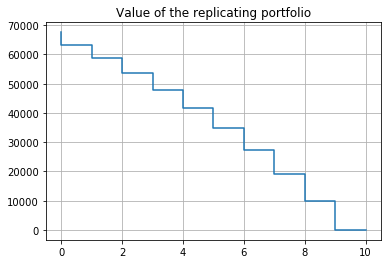

In [90]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.step(Periods,[m.y[k]() for k in Periods],where='pre')
plt.title('Value of the replicating portfolio')
plt.grid()

## Simplico Gold Mine

In [81]:
# model variables
m.W = Var(Periods,States,domain=Reals)
m.y = Var(Periods,States,domain=Reals)

# objective
m.OBJ = Objective(expr = m.W[0,0], sense=minimize)

# constraint list
m.cons = ConstraintList()

for k in Periods:
    for s in range(0,k+1):
        m.cons.add(m.W[k,s] == m.x[k,s]*Sf[k,s] + m.y[k,s]*(1+r)**k)

for s in States:
    m.cons.add(m.W[N,s] >= 0)

for k in range(0,N):
    for s in range(0,k+1):
        m.cons.add(m.x[k,s]*Sf[k+1,s] + m.y[k,s]*B[k+1] >= m.W[k+1,s] + max(0,(Sf[k,s]-200)))
        m.cons.add(m.x[k,s]*Sf[k+1,s+1] + m.y[k,s]*B[k+1] >= m.W[k+1,s+1] + max(0,(Sf[k,s]-200)))

SolverFactory('glpk').solve(m)   

	This is usually indicative of a modelling error.
	To avoid this warning, use block.del_component() and block.add_component().


RuntimeError: Cannot add component 'y_index' (type <class 'pyomo.core.base.sets._SetProduct'>) to block 'unknown': a component by that name (type <class 'pyomo.core.base.sets.SimpleSet'>) is already defined.

## Binomial Model

The binomial model provides a means of modeling the statistical distribution of future prices. Given a current price $S_t$, there are two possible states for the next observed value $S_{t+\Delta t}$

$$S_{t + \Delta t} = \begin{cases} u S_t & \mbox{with probability } p \\ d S_t & \mbox{with probability } 1-p\end{cases}$$

The model extends to multiple time steps in a natural way as shown in this diagram:

![](../img/BinomialModel.png)

Note that each step forward in time introduces an additional state to the set of possible outcomes.

For the purpose of coding, we will use Python dictionaries to store future prices $S^f$. Future prices are indexed by two subscripts, $k$ and $s$, such that ``Sf[k,s]`` corresponds to the price at time $t + k\Delta t$ in state $s$.

We start by setting the initial node equal to the last observed price, $S^f_{0,0} = S_t$. For each $k$ and $s$ there are two subsequent nodes

\begin{align*}
S^f_{k + 1, s} & = u S^f_{k,s} \\
S^f_{k + 1, s + 1} & = d S^f_{k,s}
\end{align*}

These two equations can be combined by eliminating the common term $S^f_{k,s}$ to yield

\begin{align*}
S^f_{k + 1, s} & = u S^f_{k,s} \\
S^f_{k+1,s+1} & = \frac{d}{u} S^f_{k+1,s}
\end{align*}

These formula can be solved explicit to give

$$S^f_{k,s} = u^{k-s}d^{s}S^f_{0,0}$$

which is the formula used below to compute values in the binomial lattice.

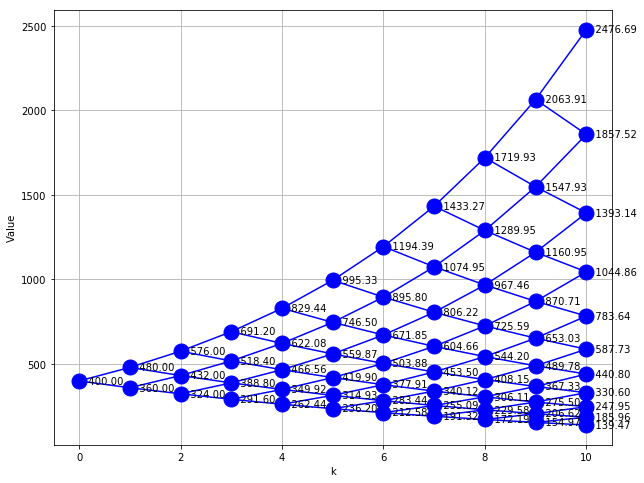

In [34]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

N = 10
u = 1.2
d = 0.9
p = 0.75
r = 0.10

# initialize Sf
Sf = {}
Sf[0,0] = 400

# compute values
for k in range(1,N+1):
    for s in range(0,k+1):
        Sf[k,s] = u**(k-s)*d**s*Sf[0,0]
      
%matplotlib inline
def Sdisplay(Sf):
    plt.figure(figsize=(10,8))
    for k,s in Sf.keys():
        plt.plot(k,Sf[k,s],'.',ms=30,color='b')
        plt.text(k,Sf[k,s],'   {0:.2f}'.format(Sf[k,s]),ha='left',va='center')
        if (k > 0) & (s < k):
            plt.plot([k-1,k],[Sf[k-1,s],Sf[k,s]],'b')
            plt.plot([k-1,k],[Sf[k-1,s],Sf[k,s+1]],'b')
    plt.xlabel('k')
    plt.ylabel('Value')
    plt.grid()
    
Sdisplay(Sf)

The probability of reaching state $s$ at time step $k$ is denoted by $P_{k,s}$. This can be computed given probability of preceding states and the conditional probabilities $p$ and $1-p$.

\begin{align*}
P_{k,s} & = p P_{k-1,s} + (1-p) P_{k-1,s-1}
\end{align*}

The following cell evaluates price and probability for a binomial model, and also plot the average price.

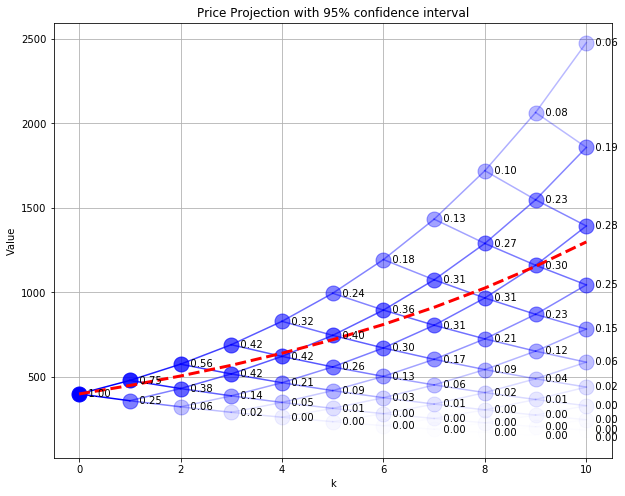

In [35]:
P = {}
P[0,0] = 1

for k in range(0,N):
    P[k+1,0] = p*P[k,0]
    P[k+1,k+1] = (1-p)*P[k,k]
    for s in range(1,k+1):
        P[k+1,s] = p*P[k,s] + (1-p)*P[k,s-1]

%matplotlib inline
def SPdisplay(Sf,P,D):
    plt.figure(figsize=(10,8))
    nPeriods = max([k for k,s in Sf.keys()]) + 1
    Sfmean = np.zeros(N+1)
    for k,s in Sf.keys():
        Sfmean[k] += Sf[k,s]*P[k,s]
        plt.plot(k,Sf[k,s],'.',ms=30,color='b',alpha=np.sqrt(P[k,s]))
        if (k > 0) & (s < k):
            plt.plot([k-1,k],[Sf[k-1,s],Sf[k,s]],'b',alpha=np.sqrt(P[k-1,s]))
            plt.plot([k-1,k],[Sf[k-1,s],Sf[k,s+1]],'b',alpha=np.sqrt(P[k-1,s]))
    for k,s in D.keys():
        plt.text(k,Sf[k,s],'   {0:.2f}'.format(D[k,s]),ha='left',va='center')
    plt.plot(range(0,N+1),Sfmean,'r--',lw=3)
    plt.xlabel('k')
    plt.ylabel('Value')
    plt.grid()
    plt.title('Price Projection with 95% confidence interval')
SPdisplay(Sf,P,P)


## Implementing a Replicating Portfolio with Pyomo

A replicating portfolio is the key concept that allows use of the binomial model for pricing options. In a nutshell, the value of an option is the money needed to construct a portfolio  exactly replicate the option payoff. 

This concept can be extended to applications involving 'real assets', including processes that convert commodity resources into higher value products. As a first step, let's see how Pyomo can be used to model a replicating portfolio for a European call option.

We start with an expression for the value of the replicating portfolio at time $k$ in state $s$. For the purpose of later generalization, we use the symbol $W$ to denote wealth,

$$W_{k,s} = x_{k,s}S^f_{k,s} + y_{k,s}B_k$$

The portfolio consists of $x_{k,s}$ units of an underlying asset with a price $S^f_{k,s}$ subject to statistical variability, and $y_{k,s}$ units of a 'bond' which has a known future price and therefore depends only on $k$. For example,

$$B_k = (1 + r_f)^k B_0 $$

where $r_f$ is a risk-free interest rate. This is the 'cash' component of the portfolio.

At earlier nodes, the value of the portfolio must be sufficient to finance the portfolio as subsequent states. In the binomial model, for each node $(k,s)$ there are two subsequenct states $(k+1,s)$ and $(k+1,s+1)$. This results in two constraints:

\begin{align*}
x_{k,s}S^f_{k+1,s} + y_{k,s}B_{k+1} & \geq W_{k+1,s}  + \max(0,q (S^f_{k,s}-200))\\
x_{k,s}S^f_{k+1,s+1} + y_{k}B_{k+1} & \geq W_{k+1,s+1} + \max(0,q (S^f_{k,s}-200))
\end{align*}

If everything works as expected, the results of this calculation should be the same as those computed using risk-neutral probabilities.

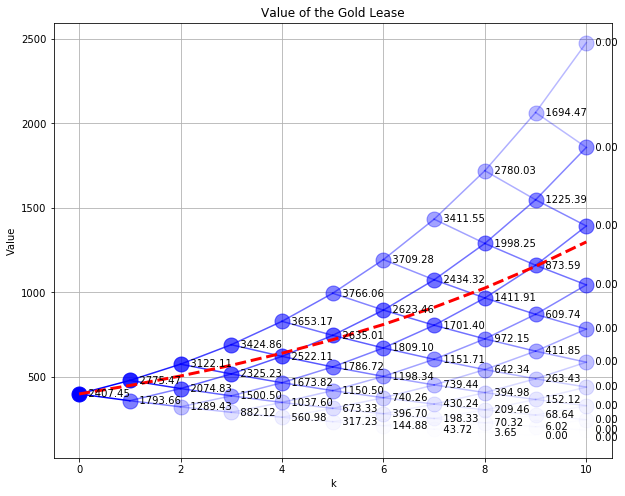

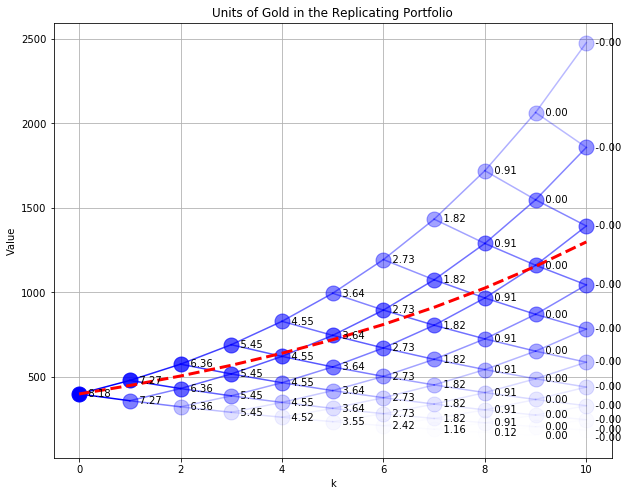

In [36]:
from pyomo.environ import *

# set of periods and states for each period
Periods = range(0,N+1)
States = range(0,N+1)

# future bond prices
B = [(1+r)**k for k in Periods]

m = ConcreteModel()

# model variables
m.W = Var(Periods,States,domain=Reals)
m.x = Var(Periods,States,domain=Reals)
m.y = Var(Periods,States,domain=Reals)

# objective
m.OBJ = Objective(expr = m.W[0,0], sense=minimize)

# constraint list
m.cons = ConstraintList()

for k in Periods:
    for s in range(0,k+1):
        m.cons.add(m.W[k,s] == m.x[k,s]*Sf[k,s] + m.y[k,s]*(1+r)**k)

for s in States:
    m.cons.add(m.W[N,s] >= 0)

for k in range(0,N):
    for s in range(0,k+1):
        m.cons.add(m.x[k,s]*Sf[k+1,s] + m.y[k,s]*B[k+1] >= m.W[k+1,s] + max(0,(Sf[k,s]-200)))
        m.cons.add(m.x[k,s]*Sf[k+1,s+1] + m.y[k,s]*B[k+1] >= m.W[k+1,s+1] + max(0,(Sf[k,s]-200)))

SolverFactory('glpk').solve(m)        

W = {}
x = {}
for k in range(0,N+1):
    for s in range(0,k+1):
        W[k,s] = m.W[k,s]()
        x[k,s] = m.x[k,s]()
        
SPdisplay(Sf,P,W)
plt.title('Value of the Gold Lease')
        
SPdisplay(Sf,P,x)
plt.title('Units of Gold in the Replicating Portfolio')